## Automatic redaction 

Isthmus / Mitchellpkt

Detects {faces, text, tattoos} in images and videos, then automatically redacts them.

Modes include:
-  Box: Draws non-filled rectangle around face (debugging mode, no privacy)
-  Blur: Applies a Gaussian Blur filter over the face, kernel size adjustable in settings
-  Block: Draws filled rectangle over face (most privacy)

Leveraging some code from a [face detection guide](https://realpython.com/traditional-face-detection-python/) and stackoverflow thread about [blurring faces](https://stackoverflow.com/questions/18064914/how-to-use-opencv-python-to-blur-faces).

## Install libraries

In [1]:
#!pip install opencv-python # << for faces
#!pip install --upgrade imutils # << for text
import cv2 as cv 
import matplotlib.pyplot as plt
import numpy as np
import os 

## Settings

In [2]:
# Variable
path_to_image = os.path.join('inputs','images','big_testfile2.png')
privacy_mode = 'blur' # options: blur block box
min_area = 2500

# Blur settings
blur_intensity = 30 # kernel width for Gaussian blur
highlight_edges = 0 # Draw boxes before blurring? [0 / 1]


In [3]:
# Static
path_to_model_face = os.path.join('inputs','models','haarcascade_frontalface_alt.xml')

## Define some functions

In [4]:
def pop_image(image):
    cv.imshow('Image', image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [5]:
def apply_redaction(image_data, bounds, privacy_mode = 'blur', blur_intensity = 30, min_area = 1000, highlight_edges = 0):
    
    # There are two different formats used for defining regions of interest
    # Here we detect based on shape of bounds data, and switch case depending on result
    # This is kind of sloppy coding, feel free to map the data to one form and make this cleaner
    bounds_format = len(bounds[0].shape) # == 3 if text style, == 1 if face style
    
    if bounds_format == 3:
        for c in bounds:
            area = cv.contourArea(c)
            if area > min_area: # 10,000 by default
                x,y,w,h = cv.boundingRect(c)
                if privacy_mode == 'box':
                    cv.rectangle(image_data, (x, y), (x + w, y + h), (36,255,12), 3)
                if privacy_mode == 'block':
                    cv.rectangle(image_data, (x, y), (x + w, y + h), (36,255,12), -1)
                if privacy_mode == 'blur':
                    blur_intensity_odd = int(np.floor(blur_intensity/2)*2+1)
                    # get the rectangle img around all the objects
                    if highlight_edges == 1:
                        cv.rectangle(image_data, (x,y), (x+w,y+h), (255,255,0), 5)
                    sub_box = filtered_image[y:y+h, x:x+w]
                    # apply a gaussian image_data on this new recangle image
                    sub_box = cv.GaussianBlur(sub_box,(blur_intensity_odd, blur_intensity_odd), 30)
                    # merge this blurry rectangle to our final image
                    image_data[y:y+sub_box.shape[0], x:x+sub_box.shape[1]] = sub_box   
                    
    if bounds_format == 1:
        if privacy_mode == 'box':
            for (column, row, width, height) in face_regions:
                cv.rectangle(
                    image_data,
                    (column, row),
                    (column + width, row + height),
                    (255, 0, 0),
                    2
                )

        if privacy_mode == 'block':
            for (column, row, width, height) in face_regions:
                cv.rectangle(
                    image_data,
                    (column, row),
                    (column + width, row + height),
                    (255, 255, 0),
                    -1,
                )

        if privacy_mode == 'blur':        
            blur_intensity_odd = int(np.floor(blur_intensity/2)*2+1)
            for f in face_regions:         # For each face in the image
                # Get the origin co-ordinates and the length and width till where the face extends
                x, y, w, h = [ v for v in f ]

                # get the rectangle img around all the faces
                if highlight_edges == 1:
                    cv.rectangle(image_data, (x,y), (x+w,y+h), (255,255,0), 5)
                sub_box = image_data[y:y+h, x:x+w]
                # apply a gaussian blur on this new recangle image
                sub_box = cv.GaussianBlur(sub_box,(blur_intensity_odd, blur_intensity_odd), 30)
                # merge this blurry rectangle to our final image
                image_data[y:y+sub_box.shape[0], x:x+sub_box.shape[1]] = sub_box
                               
    return image_data

## Import image

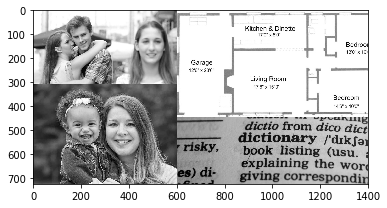

In [6]:
# Read image from your local file system
original_image = cv.imread(path_to_image)
#plt.imshow(original_image)

# Convert color image to grayscale for Viola-Jones
grayscale_image = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
plt.imshow(grayscale_image, cmap='gray')
filtered_image = original_image

## Text redaction

Identify text regions

In [7]:
image = filtered_image
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (9,9), 0)
thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,30)
kernel = cv.getStructuringElement(cv.MORPH_RECT, (9,9))
dilate = cv.dilate(thresh, kernel, iterations=4)
text_regions = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
text_regions = text_regions[0] if len(text_regions) == 2 else text_regions[1]

Redact text in the image

In [8]:
filtered_image = apply_redaction(image, text_regions, privacy_mode = privacy_mode, blur_intensity = blur_intensity, min_area = min_area, highlight_edges = highlight_edges)

## Face redaction

Identify face regions

In [9]:
face_cascade = cv.CascadeClassifier(path_to_model_face)
face_regions = face_cascade.detectMultiScale(grayscale_image)


Redact faces in the image

In [10]:
filtered_image = apply_redaction(filtered_image, face_regions, privacy_mode = privacy_mode, blur_intensity = blur_intensity, min_area = min_area, highlight_edges = highlight_edges)

## Tattoo redaction

Identify tattoo regions

In [11]:
# tattoo_regions = FXN(filtered_image, MODEL)

Redact tattoos in the image

In [12]:
# filtered_image = apply_redaction(filtered_image, tattoo_regions, privacy_mode = privacy_mode, blur_intensity = blur_intensity, min_area = min_area, highlight_edges = highlight_edges)

## Show results

Show inline (buggy colors)

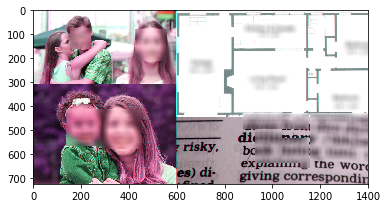

In [13]:
fig = plt.figure
plt.imshow(np.roll(filtered_image,-2))

Popout image (click into & press any key to close)

In [ ]:
pop_image(filtered_image)

Save image

In [ ]:
# face_file_name = "./face_" + str(y) + ".jpg"
# cv.imwrite(face_file_name, sub_face)